In [85]:
import numpy as np
import pandas as pd
import sklearn

from sklearn import svm, linear_model
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn import feature_selection, decomposition, ensemble, preprocessing
import matplotlib.pyplot as plt

In [2]:
def read_data(dataset_id, filename = './Destination_Dir/data/'):
    X_train = pd.read_csv(filename + 'task1_' + str(dataset_id )+ '_learn_X.csv', delimiter=' ')
    y_train = pd.read_csv(filename + 'task1_' + str(dataset_id) + '_learn_y.csv', delimiter=' ')
    return X_train.values, y_train.values.reshape(-1)

def save_predictions(model, dataset_id, filename = './Destination_Dir/data/'):
    print("FIX ME!!!!!!!!!!!!!!!!")
    X_test = pd.read_csv(filename + 'task1_' + str(dataset_id) + '_test_X.csv', delimiter=' ')
    y_test = model.predict(X_test.values)
    y_test = pd.DataFrame(y_test)
    y_test.to_csv(filename + 'task1_' + dataset_id + '_ans.csv')

def get_name(obj):
    return obj.__class__.__name__

def compute_scores(y_true, y_pred, score_functions):
    # compute scores for given score functions
    y_true = y_true.astype(int) # чтобы были int
    y_pred = y_pred.astype(int)
    scores = {f'{get_name(sf)}_{i}': sf(y_true, y_pred) for i, sf in enumerate(score_functions)}
    return scores




In [ ]:
# Init dataframe
from scipy.stats import chisquare
from statsmodels.stats.multitest import multipletests

def Behjamin_hohberg(p_val, alpha):                              # вызывалка поправки
    _, pv, *_ = multipletests(p_val, alpha, method = 'fdr_bh')
    return pv

def chi2_test(a, b):
    df_bins = pd.DataFrame()
    _, bins = pd.qcut(a, q = 10, retbins= True)
    df_bins['bin'] = pd.cut(a, bins= bins).value_counts().index
    df_bins['a_bin'] = pd.cut(a, bins = bins).value_counts().values
    df_bins['b_bin'] = pd.cut(b, bins = bins).value_counts().values
    df_bins['expected'] = df_bins['a_bin'] /np.sum(df_bins['a_bin']) *  np.sum(df_bins['b_bin'])
    stat, p_value = chisquare(df_bins['b_bin'], df_bins['expected'])
    return stat, p_value

def similarity_cross_test(X, f):
    # X.shape = (n_items, n_features)
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X)
    rez = pd.DataFrame(index= X.columns, columns= X.columns)
    for col in  range(len(X.columns)):
        for row in range(len(X.columns)):
            rez.iloc[row,col] = f(X.iloc[:,row], X.iloc[:, col])
    return rez

def similarity_test(X, y, f):
    # X.shape = (n_items, n_features)
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X)
    rez = pd.DataFrame(index= X.columns, columns= ['stat', 'p_value'])
    for ind in range(len(X.columns)):
        rez.iloc[ind] = f(X.iloc[:,ind][y > 0], X.iloc[:,ind][y == 0])
    return rez

In [3]:
# score functionss
from typing import Any


class ACC:
    def __init__(self):
        self.__name__ = self.__class__.__name__
    def __call__(self, y_true, y_pred) -> float:
        return np.mean(y_true == y_pred)
    
class NUM:
    def __init__(self):
        self.__name__ = self.__class__.__name__
    def __call__(self,  y_true, y_pred) -> float:
        return np.sum(y_pred != y_true)
class ASY:
    def __init__(self, P) -> None:
        self.P = P
        self.__name__ = self.__class__.__name__ + f'_{P}'
    def __call__(self, y_true, y_pred) -> float:
        return np.sum(self.P[y_true.astype(int), y_pred.astype(int)])

In [208]:
from sklearn.decomposition import PCA
dataset_id = 10
alpha = 0.07
X, y = read_data(dataset_id)
f, pv = feature_selection.f_classif(X, y)
p_vals = similarity_test(X, y, chi2_test).p_value
p_vals = Behjamin_hohberg(p_vals, alpha)
X = X[:, p_vals < alpha]
print(X.shape)
score_functions = [ACC(), NUM(), ASY(np.array([[-9, 9],[1, 0]]),), ASY(np.array([[-1, 3],[2, -1]]))]
greater_is_better = [True, False, False,False]
sklearn_score_functions = {f'{get_name(sf)}_{i}': make_scorer(sf, greater_is_better=greater_is_better[i]) for i, sf in enumerate(score_functions)}
# X = np.cos(X)
model = make_pipeline(
    StandardScaler(),
    # decomposition.KernelPCA(10, kernel='rbf'),
    # preprocessing.PolynomialFeatures(degree=2),
    # decomposition.KernelPCA(500, kernel='rbf'),
    svm.SVC(kernel='rbf', C=0.8)
    # ensemble.GradientBoostingClassifier(n_estimators=10)
    # ensemble.RandomForestClassifier()
)
rez = cross_validate(model, X, y, scoring= sklearn_score_functions, cv = 5, n_jobs= -2 , return_estimator= True, return_train_score=True)
rez


(999, 1020)


{'fit_time': array([0.26092315, 0.25567627, 0.25221467, 0.28957605, 0.26171803]),
 'score_time': array([0.0691669 , 0.06193209, 0.06238914, 0.06328392, 0.06287313]),
 'estimator': [Pipeline(steps=[('standardscaler', StandardScaler()), ('svc', SVC(C=0.8))]),
  Pipeline(steps=[('standardscaler', StandardScaler()), ('svc', SVC(C=0.8))]),
  Pipeline(steps=[('standardscaler', StandardScaler()), ('svc', SVC(C=0.8))]),
  Pipeline(steps=[('standardscaler', StandardScaler()), ('svc', SVC(C=0.8))]),
  Pipeline(steps=[('standardscaler', StandardScaler()), ('svc', SVC(C=0.8))])],
 'test_ACC_0': array([0.61      , 0.61      , 0.61      , 0.61      , 0.61306533]),
 'train_ACC_0': array([0.81226533, 0.81476846, 0.82102628, 0.79599499, 0.80375   ]),
 'test_NUM_1': array([-78, -78, -78, -78, -77]),
 'train_NUM_1': array([-150, -148, -143, -163, -157]),
 'test_ASY_2': array([1020, 1020, 1020, 1020, 1021]),
 'train_ASY_2': array([4242, 4244, 4249, 4229, 4235]),
 'test_ASY_3': array([-34, -34, -34, -34, -

In [201]:
np.mean(y == 0)

0.6356356356356356

In [31]:
from sklearn import decomposition

pca = decomposition.KernelPCA(100, kernel='rbf')
pca.fit_transform(X)

array([[-7.98411466e+07, -1.16873205e+08, -2.75970829e+08, ...,
         8.15097813e+07,  3.41212977e+08, -2.06413322e+08],
       [-2.32795382e+07, -7.04274110e+07,  2.47894951e+08, ...,
        -1.72300057e+08,  2.55791565e+08, -4.14286216e+07],
       [ 1.52881009e+07, -4.95146278e+07,  4.58152864e+07, ...,
        -3.14608340e+08,  1.11475456e+08,  5.77485950e+06],
       ...,
       [-1.28054215e+08,  1.91880553e+08, -2.81788510e+08, ...,
         6.61712818e+08,  4.75765765e+08,  1.09261793e+08],
       [-2.94965037e+08, -1.22275357e+08, -2.35069417e+08, ...,
        -2.38461949e+08, -1.92114364e+08, -3.15504408e+08],
       [-5.84168316e+07, -1.50929193e+08,  6.74396707e+07, ...,
         1.87536962e+07, -3.54495124e+08, -1.67283708e+08]])

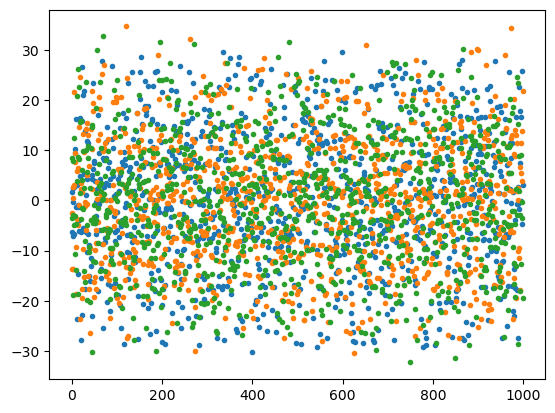

In [12]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components= 3, learning_rate='auto', init='random', perplexity=3)
X_tr = tsne.fit_transform(X, y =y)
plt.plot(X_tr, '.')

In [81]:
pd.DataFrame(StandardScaler.fit_transform(X)).describe()

AttributeError: 'numpy.ndarray' object has no attribute 'fit'

In [127]:
data = np.concatenate([X, y[:, None]], axis = 1)
pd.DataFrame(data).corr().round(3).style.background_gradient(cmap='coolwarm')

0      1      2      3      4      5      6      7      8      9   ...  \
0   1.000 -0.032 -0.011 -0.019 -0.015  0.022  0.006 -0.006 -0.022  0.005  ...   
1  -0.032  1.000 -0.004 -0.008 -0.027 -0.007 -0.017 -0.004 -0.052 -0.005  ...   
2  -0.011 -0.004  1.000  0.061  0.014 -0.022  0.006  0.004  0.040 -0.033  ...   
3  -0.019 -0.008  0.061  1.000 -0.016 -0.028 -0.014  0.036  0.028 -0.024  ...   
4  -0.015 -0.027  0.014 -0.016  1.000 -0.024 -0.025  0.008 -0.057 -0.022  ...   
5   0.022 -0.007 -0.022 -0.028 -0.024  1.000 -0.038 -0.003 -0.006 -0.000  ...   
6   0.006 -0.017  0.006 -0.014 -0.025 -0.038  1.000 -0.037  0.016  0.016  ...   
7  -0.006 -0.004  0.004  0.036  0.008 -0.003 -0.037  1.000 -0.002  0.020  ...   
8  -0.022 -0.052  0.040  0.028 -0.057 -0.006  0.016 -0.002  1.000 -0.062  ...   
9   0.005 -0.005 -0.033 -0.024 -0.022 -0.000  0.016  0.020 -0.062  1.000  ...   
10  0.004  0.001  0.000  0.014  0.041  0.004 -0.013  0.028  0.028 -0.008  ...   
11  0.032 -0.002  0.012  0.057  0.033  0.006 -0.010  0.057 -0.002 -0.008  ...   
12  0.001  0.016  0.019  0.032  0.051  0.008 -0.012 -0.021  0.012 -0.037  ...   
13 -0.000 -0.053  0.013 -0.037  0.053 -0.016 -0.048 -0.020 -0.010 -0.061  ...   
14  0.012 -0.051  0.067  0.043 -0.030 -0.070  0.023  0.057 -0.106 -0.012  ...   
15 -0.019  0.008 -0.016  0.003  0.005 -0.024  0.035 -0.012  0.013  0.006  ...   
16  0.010  0.008  0.062  0.016 -0.026  0.031  0.033  0.059  0.047  0.009  ...   
17 -0.010  0.022  0.011 -0.011 -0.010 -0.029  0.034  0.024  0.043  0.018  ...   
18 -0.010  0.014 -0.015 -0.007 -0.005 -0.005  0.024  0.013 -0.030 -0.080  ...   
19  0.034 -0.054  0.006 -0.029  0.020  0.001 -0.008 -0.057  0.030  0.000  ...   
20  0.005  0.009 -0.063  0.034 -0.029  0.011  0.009 -0.023  0.032 -0.023  ...   

       11     12     13     14     15     16     17     18     19     20  
0   0.032  0.001 -0.000  0.012 -0.019  0.010 -0.010 -0.010  0.034  0.005  
1  -0.002  0.016 -0.053 -0.051  0.008  0.008  0.022  0.014 -0.054  0.009  
2   0.012  0.019  0.013  0.067 -0.016  0.062  0.011 -0.015  0.006 -0.063  
3   0.057  0.032 -0.037  0.043  0.003  0.016 -0.011 -0.007 -0.029  0.034  
4   0.033  0.051  0.053 -0.030  0.005 -0.026 -0.010 -0.005  0.020 -0.029  
5   0.006  0.008 -0.016 -0.070 -0.024  0.031 -0.029 -0.005  0.001  0.011  
6  -0.010 -0.012 -0.048  0.023  0.035  0.033  0.034  0.024 -0.008  0.009  
7   0.057 -0.021 -0.020  0.057 -0.012  0.059  0.024  0.013 -0.057 -0.023  
8  -0.002  0.012 -0.010 -0.106  0.013  0.047  0.043 -0.030  0.030  0.032  
9  -0.008 -0.037 -0.061 -0.012  0.006  0.009  0.018 -0.080  0.000 -0.023  
10  0.019  0.054 -0.017  0.017 -0.002  0.051 -0.027 -0.035 -0.061  0.031  
11  1.000 -0.059 -0.027  0.022 -0.027  0.007  0.046 -0.038  0.005  0.022  
12 -0.059  1.000 -0.028  0.024  0.039 -0.066  0.030 -0.051 -0.019  0.009  
13 -0.027 -0.028  1.000  0.036 -0.060 -0.001  0.000  0.071 -0.014  0.053  
14  0.022  0.024  0.036  1.000 -0.019  0.058 -0.026 -0.026  0.036 -0.054  
15 -0.027  0.039 -0.060 -0.019  1.000  0.008 -0.061  0.024  0.011  0.013  
16  0.007 -0.066 -0.001  0.058  0.008  1.000  0.031 -0.019 -0.010  0.063  
17  0.046  0.030  0.000 -0.026 -0.061  0.031  1.000  0.030  0.036  0.005  
18 -0.038 -0.051  0.071 -0.026  0.024 -0.019  0.030  1.000  0.004 -0.038  
19  0.005 -0.019 -0.014  0.036  0.011 -0.010  0.036  0.004  1.000 -0.000  
20  0.022  0.009  0.053 -0.054  0.013  0.063  0.005 -0.038 -0.000  1.000  

[21 rows x 21 columns]

/Users/ilgam/miniconda3/envs/ml/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/ilgam/miniconda3/envs/ml/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/ilgam/miniconda3/envs/ml/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/ilgam/miniconda3/envs/ml/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. 

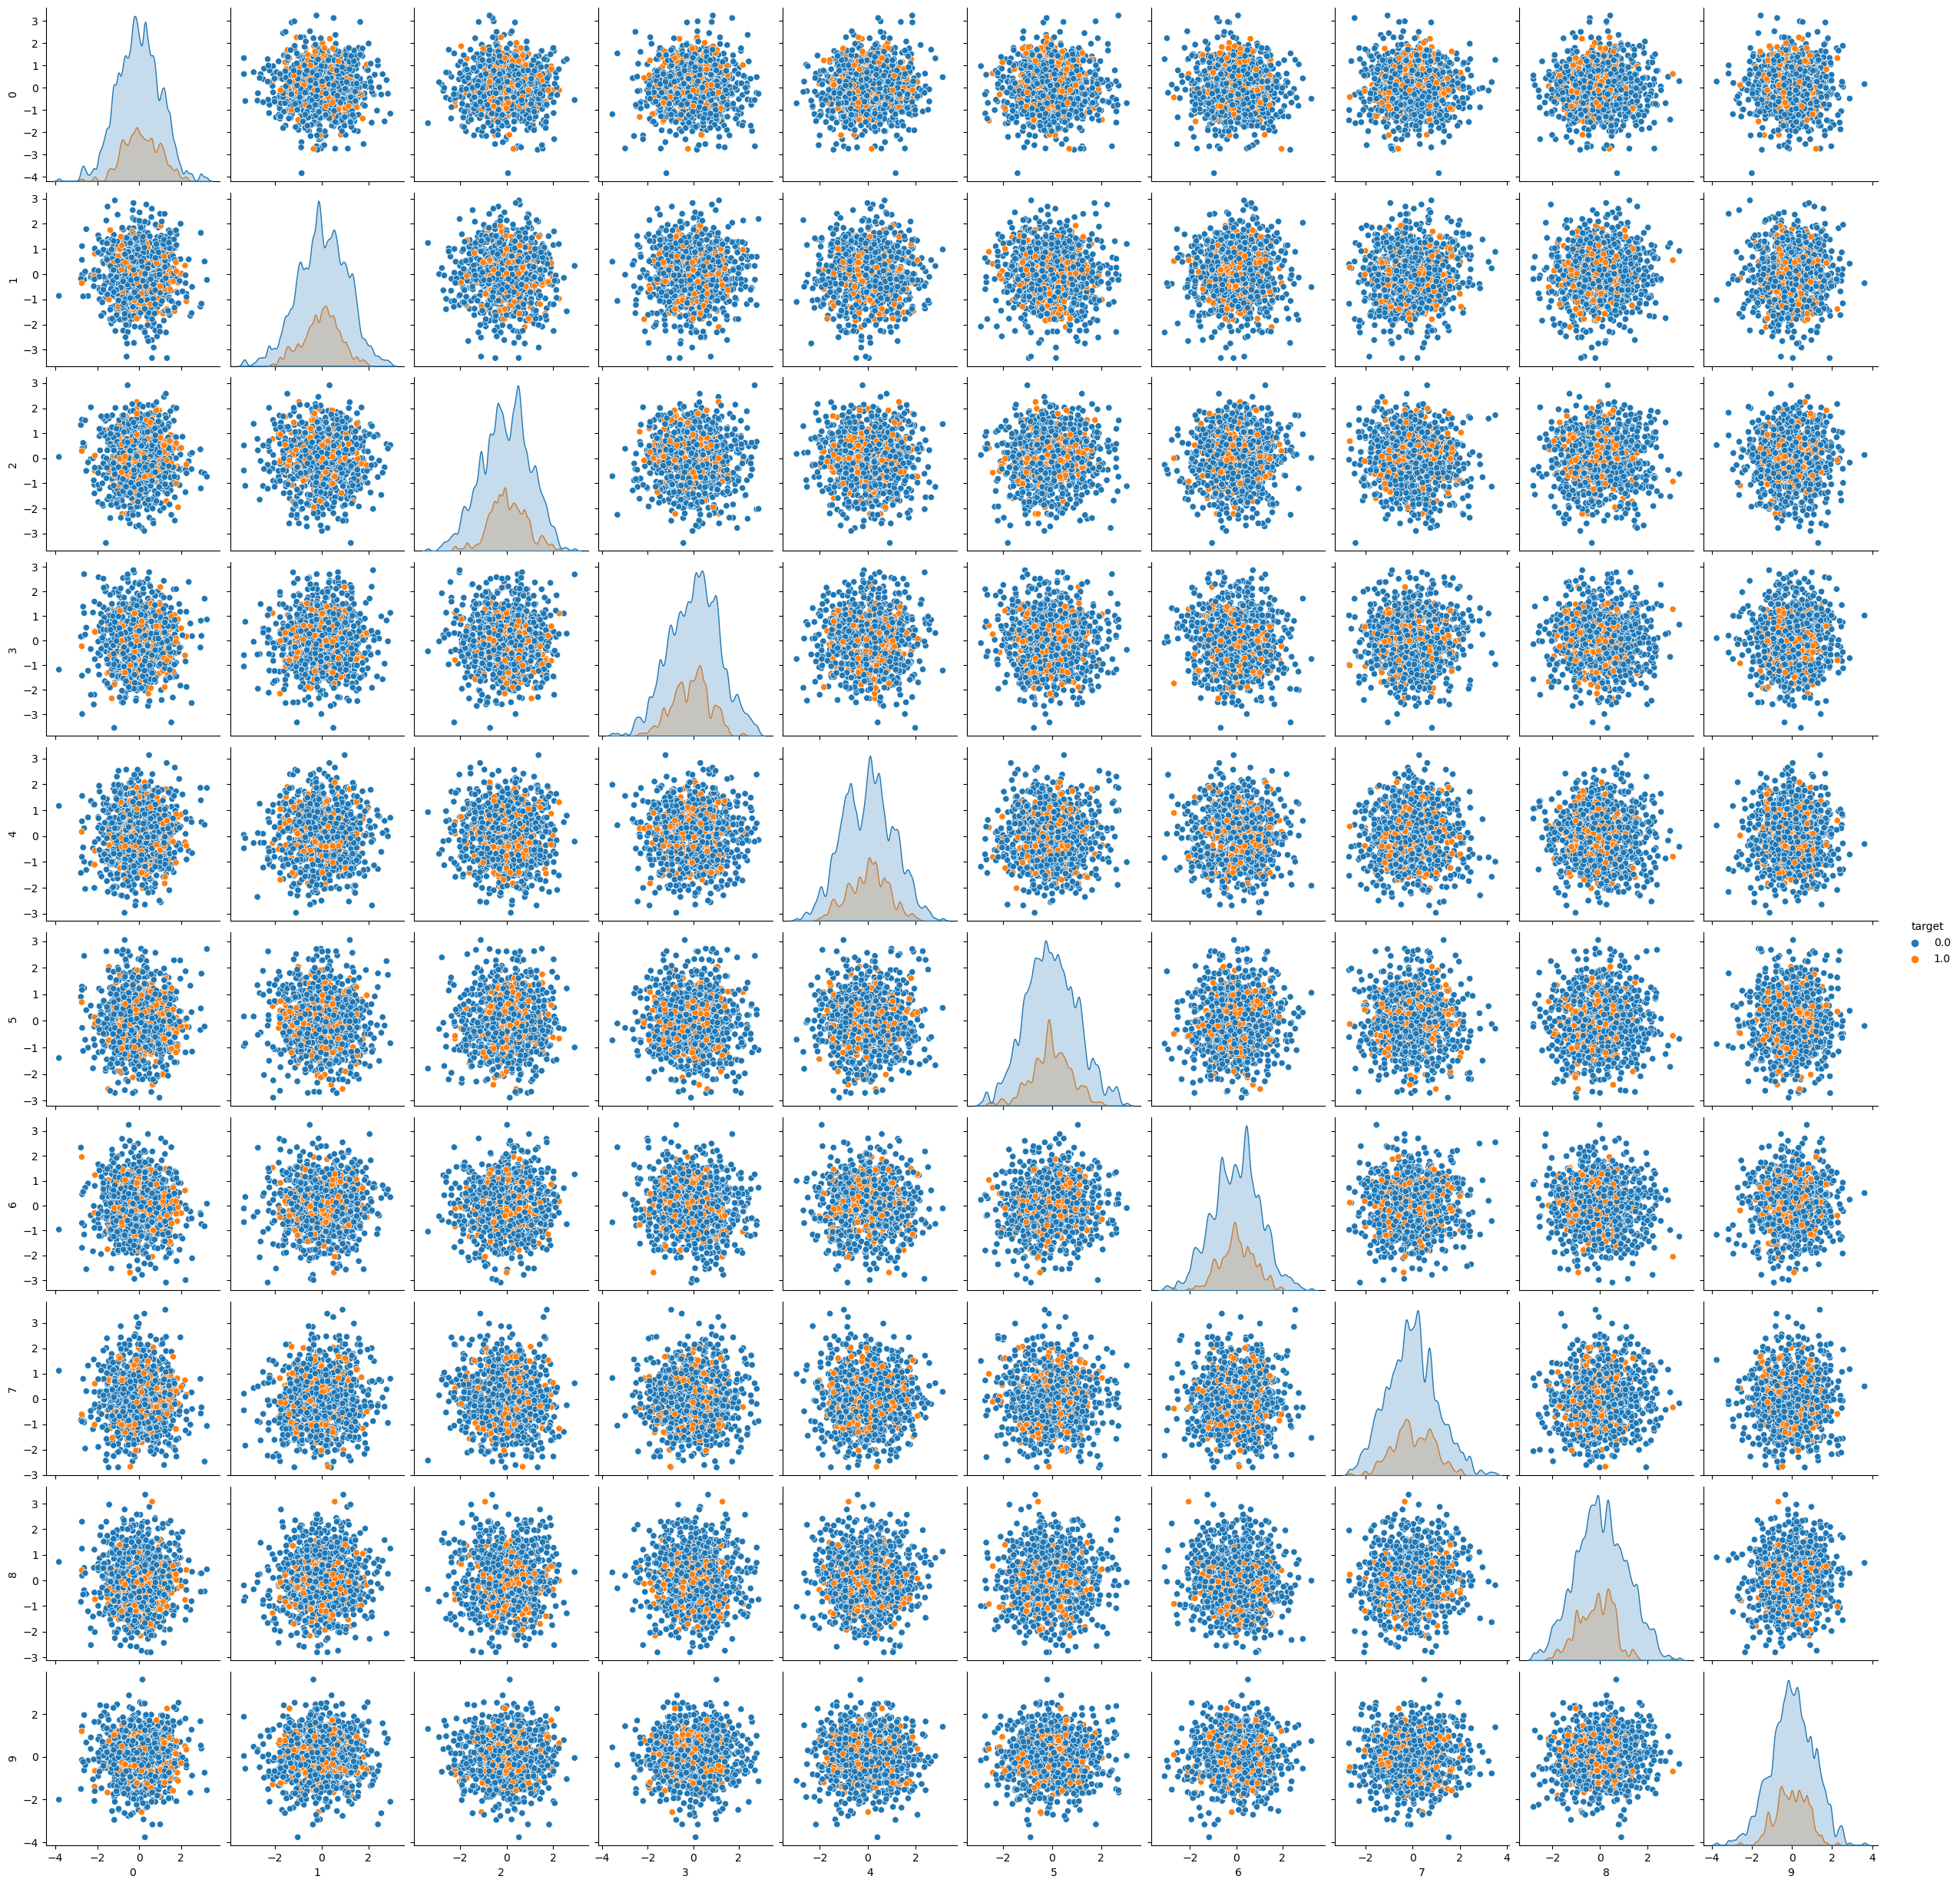

In [209]:
# importing the required libraries 
import seaborn as sbn 
import matplotlib.pyplot as plt 
# loading the dataset using the seaborn library 
# pairplot with the hue = gender parameter 
dataset_id = 11
alpha = 0.07
n = 10
X, y = read_data(dataset_id)
f, pv = feature_selection.f_classif(X, y)
p_vals = similarity_test(X, y, chi2_test).p_value

bound = sorted(p_vals)[n]
X = X[:, p_vals < bound]

data = pd.DataFrame(X)
data['target'] = y
sbn.pairplot(data, hue = 'target', diag_kws={'bw_adjust': 0.3}) 
# displaying the plot 
plt.show() 

In [210]:
np.mean(y == 0)

0.7817817817817818

In [132]:
# Init dataframe
from scipy.stats import chisquare
from statsmodels.stats.multitest import multipletests

def Behjamin_hohberg(p_val, alpha):                              # вызывалка поправки
    _, pv, *_ = multipletests(p_val, alpha, method = 'fdr_bh')
    return pv

def chi2_test(a, b):
    df_bins = pd.DataFrame()
    _, bins = pd.qcut(a, q = 10, retbins= True)
    df_bins['bin'] = pd.cut(a, bins= bins).value_counts().index
    df_bins['a_bin'] = pd.cut(a, bins = bins).value_counts().values
    df_bins['b_bin'] = pd.cut(b, bins = bins).value_counts().values
    df_bins['expected'] = df_bins['a_bin'] /np.sum(df_bins['a_bin']) *  np.sum(df_bins['b_bin'])
    stat, p_value = chisquare(df_bins['b_bin'], df_bins['expected'])
    return stat, p_value

def similarity_cross_test(X, f):
    # X.shape = (n_items, n_features)
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X)
    rez = pd.DataFrame(index= X.columns, columns= X.columns)
    for col in  range(len(X.columns)):
        for row in range(len(X.columns)):
            rez.iloc[row,col] = f(X.iloc[:,row], X.iloc[:, col])
    return rez

def similarity_test(X, y, f):
    # X.shape = (n_items, n_features)
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X)
    rez = pd.DataFrame(index= X.columns, columns= ['stat', 'p_value'])
    for ind in range(len(X.columns)):
        rez.iloc[ind] = f(X.iloc[:,ind][y > 0], X.iloc[:,ind][y == 0])
    return rez

In [135]:
table = similarity_cross_test(X, lambda a, b: chi2_test(a,b)[1]).round(3)
table.style.background_gradient(cmap='coolwarm')

In [171]:
from statsmodels.stats.multitest import multipletests
alpha = 0.01
dataset_id = 10

X, y = read_data(dataset_id)

def Behjamin_hohberg(p_val, alpha):                              # вызывалка поправки
    _, pv, *_ = multipletests(p_val, alpha, method = 'fdr_bh')
    return pv

test_table = similarity_test(X, y, chi2_test)
p_vals = test_table.p_value
print(np.mean(p_vals < alpha))

p_vals = Behjamin_hohberg(p_vals, alpha)

print(np.mean(p_vals < alpha))

0.466
0.34


In [155]:
similarity_test(X, y, chi2_test)

stat   p_value
0    7.999029  0.534244
1   21.393172  0.011015
2   18.630172  0.028528
3   20.301217  0.016142
4   11.876244  0.220376
5    9.911437  0.357702
6   21.849741  0.009368
7   12.214207  0.201501
8   19.231807  0.023292
9   20.607169  0.014514
10   2.060192   0.99048
11  10.838773  0.286922
12  15.382341  0.080955
13  19.484392  0.021375
14   23.88384  0.004489
15  17.634722  0.039656
16    15.1874  0.085915
17  19.728704  0.019663
18  17.647695  0.039488
19  21.837769  0.009408